<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Alkhatib/2currentcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


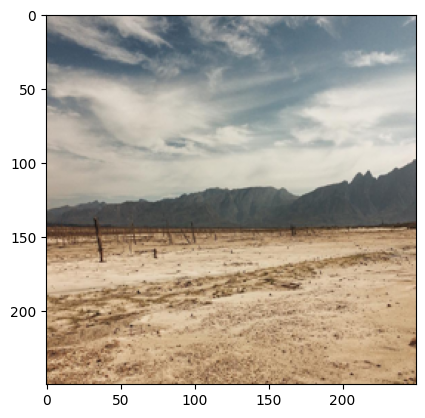

In [73]:
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize
#         # Remove the np.expand_dims call here to avoid extra dimension
#         return image
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# folder = '/content/drive/MyDrive/Colab_Notebooks/multimodel/Sample Pictures'
# images = []
# for image_file in os.listdir(folder): # Iterate through files in the directory
#     if image_file.endswith(('jpg', 'jpeg', 'png')):
#         image_path = os.path.join(folder, image_file)
#         processed_image = preprocess_image(image_path) # Process individual image
#         if processed_image is not None:
#             images.append(processed_image)

# # Convert the list of images directly into a NumPy array with correct dimensions
# images = np.stack(images, axis=0)

# # Now, the image at index 0 can be displayed
# plt.imshow(images[3])

In [75]:
# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        image = np.array(image) / 255.0  # Normalize pixel values
        return np.expand_dims(image, axis=0)  # Add batch dimension (1, 250, 250, 3)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
folder = '/content/drive/MyDrive/Colab_Notebooks/multimodel/Sample Pictures'
images = []
# Get and sort image files
image_files = sorted([file for file in os.listdir(folder) if file.endswith(('jpg', 'jpeg', 'png'))])
# Process each image
for image_file in image_files:
    image_path = os.path.join(folder, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        images.append(processed_image)

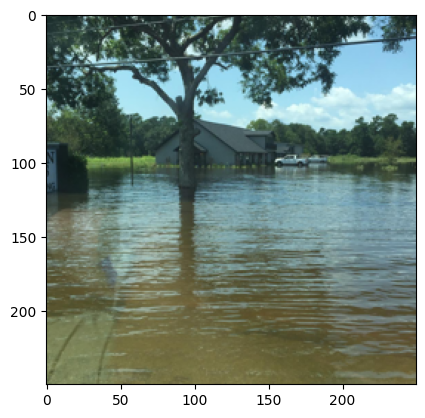

In [94]:
images[0].shape # Change Images to images
import matplotlib.pyplot as plt
plt.imshow((images[16][0] * 255).astype('uint8'))# Access the first image from the list of arrays

In [103]:
# Create a mapping dictionary for the indices
index_to_label = {
    0: 'flood',
    1: 'human',
    2: 'human',
    3: 'human',
    4: 'human',
    5: 'building collapse',
    6: 'building collapse',
    7: 'building collapse',
    8: 'fire',
    9: 'fire',
    10: 'building collapse',
    11: 'flood',
    12: 'drought',
    13: 'drought',
    14: 'drought',
    15: 'drought',
    16: 'flood',
    17: 'flood',
    18: 'fire',
    19: 'fire'
}
# Map the index to the corresponding label
data = pd.DataFrame({'image': images})
data.head()

data['label'] = [index_to_label[i] for i in range(len(data))] # Display the first few rows of the DataFrame to check the resultprint(data.head())

In [3]:
#Load the data from pkl files
def load_data_from_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as f:
       df = pickle.load(f)
    return df

df = load_data_from_pkl('/content/drive/MyDrive/Colab_Notebooks/multimodel/disaster_data.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/Colab Notebooks/multimodel"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# images = np.array([np.array(image) for image in images])
type(images)

list

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',
#                                    })

In [5]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.00392157 0.07058824 0.21960784], [0.0078...",Hey Prepsters!\n\nCome experience the @RBC Avi...,ad,non-damage,non-damage
5297,"[[[[0.09803922 0.12941176 0.14509804], [0.1333...",And so beings... the end.,landslide,landslide,damage
1121,"[[[[0.32941176 0.32941176 0.32941176], [0.3137...",Alone under fhe bridge © 2016 #flexaret @flexa...,wreckedcar,wreckedcar,damage
561,"[[[[0.03137255 0.03137255 0.03137255], [0.0313...",Nepal 🇳🇵 Damage after the earthquake \n#nepal ...,earthquakenepal,earthquake,damage
1188,"[[[[0.96470588 0.96862745 0.9372549 ], [0.9647...",After playing #fallout3 for years I suddenly r...,wreckedcar,wreckedcar,damage


In [6]:
df['label_2'].value_counts()

,count
label_2,
non-damage,503
earthquake,99
hurricane,93
wreckedcar,73
fire,61
war,49
flood,47
naturaldisaster,36
landslide,18


In [7]:
df['label_3'].value_counts()

,count
label_3,
non-damage,503
damage,497


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [9]:
X_image = df['image']
X_text = df['text']
y = df['label_3']

In [10]:
new_X_image = []
for row in X_image:
    for image in row:
        new_X_image.append(image)

new_X_image[0]

X_image = [np.array(img).astype(np.float32) for img in new_X_image]

In [11]:
resized_X_image = []

for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

X_image = np.array(resized_X_image)

In [12]:
print(X_image.shape)
print(X_image[0].shape)

(1000, 250, 250, 3)
(250, 250, 3)


In [13]:
y = y.replace({'damage': 1, 'non-damage': 0})

<ipython-input-13-29e6a47d55c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'damage': 1, 'non-damage': 0})


Function for creating DataFrame with label

# Model Ideas

In [ ]:
%load_ext tensorboard

In [177]:
%reload_ext tensorboard

In [122]:
# pip install -U tensorboard-plugin-profile

In [180]:
!kill 108690

In [178]:
tf.compat.v1.reset_default_graph()

In [ ]:
%tensorboard --logdir C:\Users\Logs

In [185]:
# Split your image and text data
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_image, X_text, y, test_size=0.2, random_state=42
)

In [186]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import datetime

In [187]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_image)

# Transfer learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_model.trainable = True  # Freeze base model layers

# Fine-tune from this layer onwards
fine_tune_at = 100  # Example: unfreeze the last 100 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Set the learning rate (optional)
model.optimizer.learning_rate.assign(0.0001) # Correct way to set learning rate using assign

# Callbacks
base_log_dir = "C:/Users/Logs"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"{base_log_dir}/run_{current_time}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch='10,20')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 250, 250, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 256, 256, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 125, 125, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 125, 125, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 125, 125, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 127, 127, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 63, 63, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 63, 63, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 63, 63, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 63, 63, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 63, 63, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 63, 63, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 63, 63, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 63, 63, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 63, 63, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 19,715,329 (75.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [188]:
# Train the model
batch_size = 64  # Define batch_size here
learning_rate = 0.0001  # Define learning_rate here, matching the value set in ipython-input-174-c3cd7f27836b

history = model.fit(
    datagen.flow(X_train_image, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test_image, y_test),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)
run_name = f"batchsize_{batch_size}_lr_{learning_rate}_{current_time}"
log_dir = f"{base_log_dir}/{run_name}"

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - accuracy: 0.5165 - loss: 0.7313 - val_accuracy: 0.5300 - val_loss: 0.6898 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - accuracy: 0.6653 - loss: 0.6318 - val_accuracy: 0.5300 - val_loss: 0.7001 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.5976 - loss: 0.6725 - val_accuracy: 0.5300 - val_loss: 0.7143 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.6568 - loss: 0.6312 - val_accuracy: 0.5300 - val_loss: 0.7064 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 8s/step - accuracy: 0.6821 - loss: 0.5899 - val_accuracy: 0.5300 - val_loss: 0.7092 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.6922 - loss: 0.5892 - val_accuracy: 0.5300 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.6665 - loss: 0.

Results below:
- 78.5% accuracy! Early Stopping: The training stopped at epoch 48/50 because the EarlyStopping callback was triggered. This means that the validation loss (val_loss, which is represented by the first value in the output [0.4836439788341522, 0.7850000262260437]) stopped improving for a certain number of epochs (the patience parameter I set to 10). Early stopping helps prevent overfitting by stopping the training process when the model starts to perform worse on unseen data.
Improved Accuracy: The accuracy on the validation set is 78.5% (0.7850000262260437 in the output). This indicates that the model has learned to generalize better to new data, which is the goal of machine learning.
Loss: The validation loss is 0.4836 (0.4836439788341522 in the output). This represents the error of the model's predictions on the validation set. A lower loss is generally better.

In [190]:
!pip install Flask

from flask import Flask, request, render_template
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

app = Flask(__name__)

# Load your trained model
model = tf.keras.models.load_model('path/to/your/saved/model.h5') # Replace with your model path

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Get the image file from the request
        file = request.files['image']

        # Preprocess the image
        img = image.load_img(file, target_size=(250, 250))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        # Make a prediction
        prediction = model.predict(img)

        # Interpret the prediction (assuming binary classification)
        if prediction[0][0] > 0.5:
            result = 'Positive'
        else:
            result = 'Negative'

        return render_template('index.html', prediction=result)

    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'path/to/your/saved/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [189]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7901 - loss: 0.4756


[0.4836439788341522, 0.7850000262260437]

In [176]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7560 - loss: 0.5078


[0.5092589259147644, 0.75]

Results below:
- Unforze ResNet50. Applied fine-tuning to the base model at 100 (unfroze the last 100 layers)

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

Results below:
- ResNet50 layers were frozen. Epochs 50

In [150]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6417 - loss: 0.6346


[0.6419775485992432, 0.6499999761581421]

In [136]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6362 - loss: 0.6130


[0.6121594905853271, 0.6600000262260437]

reran my model with epochs 100. It stopped at 37/100. The results are:
- Accuracy: 0.7282: This is the training accuracy achieved during the last epoch (epoch 37). It means the model correctly classified about 72.82% of the training data during this epoch.
loss: 0.5854: This is the training loss during the last epoch. A lower loss is generally better, indicating your model is making fewer errors on the training data.
[0.5996938347816467, 0.7149999737739563]: This output likely represents the validation loss and validation accuracy, respectively.
0.5996938347816467: Validation loss, which is slightly higher than the training loss. This is expected and indicates a small amount of overfitting.
0.7149999737739563: Validation accuracy, which is around 71.5%. This is a good sign, as it shows your model is generalizing well to unseen data.

In [120]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7282 - loss: 0.5854


[0.5996938347816467, 0.7149999737739563]

Results below:
- ResNet50 already has convolutional layers: The pre-trained ResNet50 model that we load comes with its own set of convolutional layers that have been trained on a large dataset (ImageNet). These layers have learned to extract relevant features from images.
Leveraging pre-trained features: The idea behind transfer learning is to reuse these pre-trained features and adapt them to our specific task. By using ResNet50 as a base model, we are essentially leveraging its convolutional layers to extract features from our images.
Adding new layers for classification: Instead of adding more convolutional layers, we focus on adding new layers on top of ResNet50's output to perform the classification specific to our dataset.

Results:
Significant improvement in performance compared to previous attempts:

Training accuracy: 71.20%
Validation accuracy: 69.50%
Validation loss: 0.6153

In [107]:
!pip install flask ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.7 MB/s eta 0:00:00


In [109]:
public_url = ngrok.connect(5000)  # Expose port 5000
print(f"Your app is available at: {public_url}")

NameError: name 'ngrok' is not defined

In [108]:
from flask import Flask, request, render_template

app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Get user input
        user_input = request.form.get('user_input')

        # Process input (e.g., using your model)
        # ...

        # Return result
        return render_template('index.html', result=result)
    else:
        return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [46]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7120 - loss: 0.5996


[0.6152660250663757, 0.6949999928474426]

Results below:
- Adjusted learning rate 0.00001
- Adjusted regularizers.l2(0.01)

Findings:


In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

Results below:
- Adjusted the parameter Patience from early stopping from 10 to 15. Increased epochs from 50 to 100.

Findings:
- Stagnant Accuracy: The accuracy hasn't improved significantly and the validation accuracy remains at 50%, suggesting the model might be stuck in a local minimum or a saddle point.
Low Loss: The loss values are already low and stable, indicating the model isn't overfitting.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.4701 - loss: 0.7048


[0.6984217166900635, 0.5]

Results below:
- Implemented Learning Rate Schedule: to gradually reduce the learning rate
further during training. This can help fine-tune the model towards a better solution. Adjusted Patience from 5 to 10

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5809 - loss: 0.6854


[0.6889081597328186, 0.5450000166893005]

-- Adjusted learning rate from 0.0001 to 0.00001

-- Adjusted optimizer from adam to optimizer
## Results Below:
Lower Loss: The training loss (0.7016) and validation loss (0.6962) have decreased significantly compared to previous runs. This is a positive sign, indicating the lower learning rate is helping the model converge to a better solution and make fewer errors.
Accuracy: The training accuracy (0.4727) and validation accuracy (0.5) are still low, even lower than before. However, with the significantly lower loss values, this could be a temporary effect while the model is taking smaller steps towards an optimal solution.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.4727 - loss: 0.7016


[0.6962198615074158, 0.5]

Results below: Lower Loss Values: Both the training loss (3.0280) and validation loss (2.9065) have decreased significantly compared to the previous output. This is a positive sign, indicating that the model is learning more effectively and making fewer errors. The training accuracy (0.5662) and validation accuracy (0.5650) are still relatively low. This means the model is only slightly better than random guessing (which would be 50% accuracy for a binary classification problem).

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.5662 - loss: 3.0280


[2.906517744064331, 0.5649999976158142]

Results below: increased learning rate from 0.01 to 00.1 and reverted back to L2 vs. L1 accuracy: 0.6287: This is the training accuracy achieved during the last epoch (epoch 7 in this case). It indicates that the model correctly classified about 62.87% of the training data during this epoch.
loss: 3.9712: This is the training loss during the last epoch. A lower loss generally indicates better model performance, but the value of 3.9712 seems quite high, suggesting potential issues with the model's training.
[4.066883563995361, 0.6050000190734863]: This likely represents the validation loss and validation accuracy, respectively. The validation loss (4.066...) is even higher than the training loss, and the validation accuracy (0.605...) is lower than the training accuracy.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.6287 - loss: 3.9712


[4.066883563995361, 0.6050000190734863]

Results below: Replaced ReLU with LeakyReLU. Training Accuracy (0.5709): This indicates that the model achieved around 57% accuracy on the training data during the last epoch.
Training Loss (7.0385): This represents the error between the model's predictions and the true labels on the training data. A high loss value suggests the model is still struggling to fit the training data well.
Validation Loss (7.0199): This is the loss calculated on the validation data. It's very close to the training loss, which could indicate overfitting (although it's not conclusive yet).
Validation Accuracy (0.5600): This is the model's accuracy on the validation data, around 56%. This is slightly better than random chance (50% for binary classification) but still relatively low.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5709 - loss: 7.0385


[7.019902229309082, 0.5600000023841858]

Results below: implemented early stopping to prevent overfitting by stopping the model when the performance starts to degrade. Implemented ImageSataGenerator that applies random transformations to the input images that helps to increase the size and diversity of the training data, which can improve the model's performance. The accuracy is 50.5% and loss is 0.70.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4879 - loss: 0.6985


[0.7009963393211365, 0.5049999952316284]

Results below: Accuracy: 0.5199 Loss: 5.1568. The loss of 5.1568 indicates the model's predictions are still quite far from the true labels.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.4827 - loss: 5.2711


[5.156851291656494, 0.5199999809265137]

Results below: The accuracy is around 54% and loss is 4.80. This indicates the model's predictions are slightly better than random chance but still has room for considerable improvement.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.4983 - loss: 4.8849


[4.807847499847412, 0.5400000214576721]

Results below: Added kernel_regularizer=regularizers.l2(0.01) to the Conv2D and Dense layers to apply L2 regularization, to help with overfitting. Replaced ReLU with LeakyReLU(alpha=0.1) to avoid the "dying ReLU" problem, where neurons can get stuck and stop learning. In creased Dropout rate to 0.04. Lowered learning rate to 0.0001

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4312 - loss: 1.3525


[1.3360905647277832, 0.4699999988079071]

Results below: Increased regularization strength from 0.01 to 0.05. This resulted in the accuracy slightly improving to 52.5% and the loss has decreased to 0.75.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.4867 - loss: 0.7623


[0.7537262439727783, 0.5249999761581421]

Results below: Learning rate at 0.001 and dropout from 0.3 to 0.25

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.5688 - loss: 2.1900


[2.3859763145446777, 0.5299999713897705]

Results below: Adjusted learning rate from 0.0005 to 0.001

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.4618 - loss: 0.7727


[0.7694690227508545, 0.49000000953674316]

Results below: Adjusted learning rate from 50 to 100. Adjusted learning rate from 0.0005 to 0.001

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.4535 - loss: 0.7527


[0.7537513971328735, 0.48500001430511475]

Results below: Adjusted Patience from 2 to 5. Changed the model's output layer to a single neuron with a Sigmoid activation.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.7306 - loss: 0.6930


[0.6873747110366821, 0.7350000143051147]

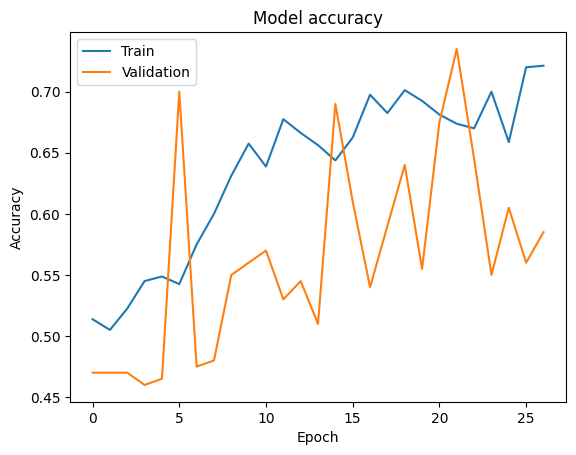

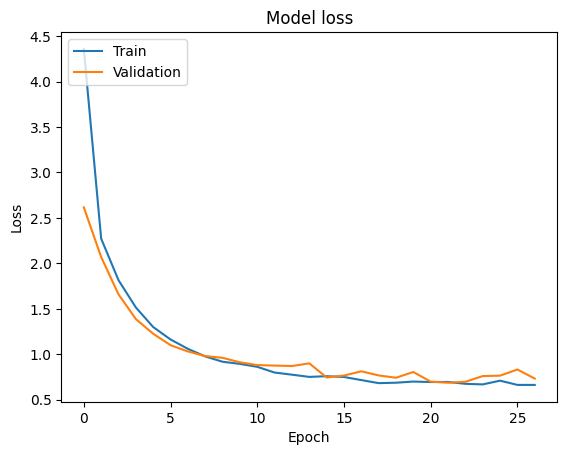

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.legend()
   plt.show()

Results below: Increased dropout rate to 0.3 Added dropout after dense layer. Created an optimizer with a lower learning rate.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.4691 - loss: 1.1413


[1.1482737064361572, 0.5]

Results below: Adjusted batch size from 64 to 32. Replaced activation function from ReLU to LeakyReLU

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.7135 - loss: 0.6542


[0.6540418267250061, 0.7350000143051147]

Results below: Added a 3rd layer

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.5121 - loss: 0.9615


[0.9434931874275208, 0.5400000214576721]

Results below: adjusted optimizer from rmsprop to adam. Adjusted outer layer activation to sigmoid. Added (Dropout(0.25)) to both convolutional layers.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.5684 - loss: 0.8126


[0.8134730458259583, 0.6000000238418579]

Results below: adjusted L2 regulization from 0.003 to 0.001. Adjusted optimizer from adam to rmsprop

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.5609 - loss: 0.7086


[0.7094149589538574, 0.5600000023841858]

Results below is with implemeting early stopping. Batch size 64, epochs 30. L2 regularization 0.003

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.6029 - loss: 0.8023


[0.8055529594421387, 0.5799999833106995]

Results below: Adjusted the L2 regularization strength from 0.001 to 0.005

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.6634 - loss: 0.6786


[0.6886732578277588, 0.6399999856948853]

Results below: Increased batch size from 32 to 64. Epochs 30

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.6004 - loss: 0.7135


[0.7167328596115112, 0.5899999737739563]

Results below: Increased number of epochs from 15 to 30.

In [ ]:
# Evaluate the model
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.4312 - loss: 0.7881


[0.7872982621192932, 0.4699999988079071]

# Creating Web Application

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from PIL import Image
import numpy as np

# Load the saved LSTM or GPT model
lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# If using GPT-2
gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

app = Flask(__name__)

# Image preprocessing function
def preprocess_image(image, target_size=(224, 224)):
    image = Image.open(image)
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Report generation endpoint
@app.route('/generate_report', methods=['POST'])
def generate_report():
    file = request.files['image']

    # Preprocess the input image
    image = preprocess_image(file)

    # Extract features from the image using CNN
    image_features = lstm_model.predict(image)  # You may want to extract features only

    # Use the LSTM or GPT model to generate a report
    # If LSTM:
    # generated_report = lstm_model.predict(image_features)

    # If GPT-2:
    input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

    report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

    return jsonify({"report": report})

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
python app.py


In [ ]:
curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
pip freeze > requirements.txt


In [ ]:
web: python app.py


In [ ]:
git init
heroku create
git add .
git commit -m "First commit"
git push heroku master
